In [2]:
%%R
library(reticulate)
use_condaenv('ethique_env')

UsageError: Cell magic `%%R` not found.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import product

from sklearn.linear_model import LogisticRegression

import seaborn as sns
sns.set_theme(style='darkgrid')

In [4]:
%%capture
%run ./german.ipynb

In [32]:
seed = 2021   # Keep results consistent through testing
NEW = False   # True : recreate all data (can be very long), False : read data from disk

# Il est plutôt facile de faire dire ce que l'on veut à un modèle

## Définition de *robustness*

[source](https://shubhobm.github.io/docs/bigdata_book_chapter.pdf)


Le concept de *robustness* n'est pas apparut avec les modèles d'apprentissage machines. C'est une notion importante en statistique et en économétrie. Il est défini de la manière suivante :

Un modèle est robuste s'il n'est pas affecté par la présence de valeurs aberrantes ou de déviation des hypothèses sur les données de départ.

Ce qui a évolué c'est la manière dont sont mis à jour les modèles. Si auparavant les modèles n'était entraîné au sein d'un laboratoire avec un grand contrôle des données d'entraînement, aujourd'hui les modèles se mettent à jour constamment et de manière automatisé. Cela implique une perte de contrôle stricte des données et une nouvelle vulnérabilité d'où l'ajout d'un nouveau rôle pour la *robustness*.

Un modèle est robuste s'il n'est pas affecté par des données qui ne sont pas similaire à ceux sur lesquels le modèle s'est entraîné.

Dans la plus part des cas ces données sont spécifiquement construite par une entité malveillante dans le but de grandement impacter les résultats du modèle de départ. C'est pour cela que cette nouvelle notion de *robustness* est nommée *adverserial robustness* (*adverserial* dans le sens conflictuel).

Il existe trois catégorisations des attaques d'*adverserial robustness* qui répondent chacune à une question : 
 - Qui est attaqué ?
 - Commet il est attaqué ?
 - Pourquoi il est attaqué ?
 
Tout comme les attaques de *privacy* les attaques d'*adverserial robustness* sont catégorisé dans un premier temps entre les attaques sur modèle boîte blanche et sur modèle boîte noire. Un modèle boite blanche est un modèle dont on peut prévoir le fonctionnement interne car on connaît toutes ces caractéristiques des éléments qui le compose. ([white box](https://fr.wikipedia.org/wiki/Bo%C3%AEte_blanche)) En apprentissage statistique cela corresponds à un modèle où l'on a accès aux données d'entraînement et de test, à la structure, aux coefficients et toutes autre information permettant de reproduire à l'identique le modèle. Les modèles boite noire est un modèle où l'on à aucune visibilité sur son fonctionnement interne, on a juste accès aux entrées et aux sorties. En apprentissage statistique cela correspond à la majorité des modèles commerciaux sous forme d'API (*Application Programming Interface*). L'utilisateur de ces modèles envois des données au modèles et ne récupère que la sortie. Les attaques *adverserial robustness* contre les modèles boîtes blanches sont rares car ils les rendent trop facile à mettre en oeuvres donc les modèles nécessitant la *robunstness* sont principalement en boite noire.

### Qui il est attaqué ?
Lors d'une attaque on peut choisir qu'elle partie du modèle sera la cible en en fonction de cela l'attaque aura un nom différent, les attaques d'évasion (*evasion attacks*), les attaques d'empoisonnement (*poisining attacks*) et les attaques d'exploration (*exploration attacks*).
Ces familles sont présentées en détail dans la suite de cette articles mais peuvent être résumé à :
 - Évasion : l'ajustement des données de test
 - Empoisonnement : l'ajustement des données d'entraînement 
 - Exploration : questionnement du modèle boite noire pour faire de la rétro-ingénierie
 
### Comment il est attaqué ?
Les raisons des attaques dépends grandement à la quantité et au type d'information dont l'adversaire dispose. 

Avant l'entraînement : 
Selon s'il a accès à la modification de la base d'entraînement ou uniquement à l'ajout à celle-ci il pourra effectuer un *data modification* ou un *data injection*. Si en revanche il a accès au modèle il pourra corrompre directement la logique de celui-ci (*logic corruption*)

Après l'entraînement : 
 - *Adaptative attacks* : on modifie nos entrées en multipliant nos requêtes jusqu'à ce que la sortie nous convienne. Soit dans le but d'une sortie spécifique soit pour créer des entrées sur lesquels le modèle ai beaucoup d'erreurs. [182,183] **METTRE DES EXEMPLES ?**
 - *Non-adaptative attacks* : on modifie nos entrées grâce à une connaissance en amont d'information sur les données d'entraînement dans le même but que pour les attaques adaptatives. 
 
### Pourquoi il est attaqué ?
On peut réduire les raisons d'une attaques à quatre grandes familles :
 - Réduction de la qualité générale de prédiction d'un modèle
 - Engendrer une erreur de classification sur toutes les entrées
 - Engendrer une erreur de classification sur tout une classe d'entrée
 - Engendrer une erreur de classification sur une entrée précise

[source](https://arxiv.org/pdf/1810.00069.pdf)

Dans la suite nous allons mettre en oeuvre deux attaques : 
 - une évasion contre un modèle boite noire de type attaque adaptative ayant pour but d'engendrer une erreur de classification sur une entrée précise.
 - un empoisonnement contre un modèle boîte noire de type *data injection* ayant pour but d'engendrer une erreur de classification sur une entrée précise.

## Description générales des différentes attaques et implémentations

Le cas de figure est le suivant, on suppose que notre banque utilise le modèle de régression logistique développé dans l'article d'introduction. Celui-ci utilise une base d'entraînement de 800 personnes et les classe en fonction de leur capacité de remboursement (0 : capable de rembourser, 1 : incapable de rembourser). Dans cette optique on peut tous à fait concevoir qu'un individu apprenant que son prêts a été refuser par le modèle cherche à contourner celui-ci. Nous présentons ici deux cas de figure. 

### Évasion

On se place dans une situation où l'individu est en mesure de questionné le modèle sans contrainte. On peut imaginer un problème de sécurité qui cause la divulgation du modèle, l'utilisation par la banque d'un modèle open source ou l'utilisation d'un modèle annexe que l'on aurait calibré grâce au méthode de *model extractio* (cf. l'article *privacy*). Le type d'attaque utilisé est une attaque adaptative donc on va chercher les variables non vérifiables et les modifiées jusqu'à ce que l'individu refusé soit accepté.

En observant les différentes variables on remaque que très peu de variables peuvent être modifier sans que cela soit vérifiable, cela paraît réaliste, c'est une base de données pour crédit.
On peut néanmoins supposé que ces deux variables peuvent être falsifié sans trop de difficulté.
 - purpose : correspond à la finalité du prêt
 - personal_status : la condition de vie en couple

Mais également ces trois autres variables paraisse difficilement vérifiable si le banquier ne prête pas attention :
 - present_emp_since : depuis quand la personne travail à son poste
 - job : le type de travaille de la personne
 - people_under_maintenance : le nombre de personne à charge
 
On choisit ensuite une personne refusé pour jouer le rôle d'adversaire :

In [148]:
idx_default = np.where(logreg.predict_proba(X)[:, 1] > 0.5)

np.random.seed(seed)
adv_ind = X.iloc[np.random.choice(idx_default[0])]
adv_ind

account_check_status                                                     < 0 DM
duration_in_month                                                            48
credit_history                         existing credits paid back duly till now
purpose                                                     domestic appliances
credit_amount                                                              6758
savings                                                            ... < 100 DM
present_emp_since                                            1 <= ... < 4 years
installment_as_income_perc                                                    3
sex                                                                      female
personal_status                                                        divorced
other_debtors                                                              none
present_res_since                                                             2
property                      if not A12

Notre individu (569) est donc une femme étrangère divorcée de 31 ans avec une personne à sa charge qui a remboursé toutes ces dettes jusqu'à aujourd'hui. Il se voit refuser sont crédit de consommation.

Pour pouvoir se faire accepter son crédit il va créé toutes les combinaisons possible pour les variables difficilement vérifiables et les faire tester par le modèle. 

In [149]:
# variables that are difficults to verify
var_values = ['purpose', 'personal_status', 
              'present_emp_since', 'job', 
              'people_under_maintenance']
# variables that are hard to falsify (all the other)
fix_values = [x for x in X.columns if x not in var_values]

# catesian product of all possibilities from variables that can change
all_values = [X[col].unique() for col in var_values]
prod = list(product(*all_values))   

# all possible entries that can be generated
all_adv_ind = pd.DataFrame([adv_ind[fix_values].tolist() + list(p) for p in prod],
                      columns=fix_values + var_values)
all_adv_ind = all_adv_ind[X.columns]

# predict the score for all entries
all_adv_ind['proba'] = logreg.predict_proba(all_adv_ind)[:, 1]

In [150]:
# take only the entries that gets a 0
valid_adv_ind = all_adv_ind[all_adv_ind.proba < 0.5]

# calculate the number of variables that were changedb
nb_diff = []
for i in range(len(valid_adv_ind)):
    val_diff = (valid_adv_ind.iloc[i][var_values] == adv_ind[var_values])
    nb_diff += [val_diff.value_counts()[False]]
    
valid_adv_ind = valid_adv_ind.assign(diff = nb_diff)

# take the least change entrie that have the biggest impact
valid_adv_ind.sort_values(by=['diff', 'proba'], inplace=True)
valid_adv_ind.head(3)

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal_status,...,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,diff
488,< 0 DM,48,existing credits paid back duly till now,car (used),6758,... < 100 DM,1 <= ... < 4 years,3,female,single,...,31,none,own,1,skilled employee / official,1,"yes, registered under the customers name",yes,0.445632,2
536,< 0 DM,48,existing credits paid back duly till now,car (used),6758,... < 100 DM,4 <= ... < 7 years,3,female,divorced,...,31,none,own,1,skilled employee / official,1,"yes, registered under the customers name",yes,0.494217,2
496,< 0 DM,48,existing credits paid back duly till now,car (used),6758,... < 100 DM,4 <= ... < 7 years,3,female,single,...,31,none,own,1,skilled employee / official,1,"yes, registered under the customers name",yes,0.331218,3


On voit donc qu'en modifiant uniquement deux des variables on peut passer d'un score de plus de 0.5 à 0.45 faisant ainsi passé notre individu de 1 à 0. Voyons maintenant quel est ce changement.

In [151]:
def print_diff(new_comb, old_comb):
    '''Print the difference between two entries'''
    diff_comb = (new_comb != old_comb)
    diff_pd = pd.DataFrame([old_comb[diff_comb], 
                            new_comb[diff_comb]], index=['old', 'new']).transpose()
    
    # juste for styling
    max_ind = max([len(x) for x in diff_pd.index])
    max_old = max([len(x) for x in diff_pd.old])
    max_new = max([len(x) for x in diff_pd.new])

    for i in new_comb[diff_comb].index :
        print('{:<{}} : {:<{}} --> {:<{}}'.format(i, max_ind,
                                                  diff_pd.old[i], max_old,
                                                  diff_pd.new[i], max_new))

In [152]:
print_diff(valid_adv_ind.iloc[0][var_values], adv_ind[var_values])

purpose         : domestic appliances --> car (used)
personal_status : divorced            --> single    


Pour passer de plus de 0.5 à 0.45 il suffit à notre individu de falsifier la raison de son prêt en disant que c'est pour une voiture d'occasion et de dire qu'elle n'a jamais été mariée.

Maintenant que nous avons fait l'étude de cas sur un individu voyons comment ce raisonnement se généralise à notre population de test.
Pour chaque individu qui se voit refuser son crédit on applique la même méthode que pour notre individu 655 et on calcul la probabilité minimal atteignable.

In [153]:
X_default = X.iloc[idx_default]

if NEW:
    all_adv_inds = []
    for idx, adv_ind in tqdm(X_default.iterrows()):
        for p in prod:
            all_adv_inds += [list(adv_ind[fix_values]) + list(p)  + [idx]]
    
    columns_name = fix_values + var_values + ['index_old']
    all_adv_inds = pd.DataFrame(all_adv_inds, columns=columns_name)
    
    all_adv_inds['proba'] = logreg.predict_proba(all_adv_inds[X.columns])[:, 1]
    
    np.savez_compressed('data/privacy/all_adv_inds.npz', 
                        data=np.array(all_adv_inds),
                        columns=all_adv_inds.columns)
else:
    file = np.load('data/privacy/all_adv_inds.npz', allow_pickle=True)
    all_adv_inds = pd.DataFrame(file['data'], columns=file['columns'])


# fonction that takes the minimum proba of a group of entries 
def min_proba(df):
    return df.sort_values('proba').head(1).proba

proba_min = all_adv_inds.groupby('index_old').apply(lambda df: min_proba(df))
X_default = X_default.assign(proba = logreg.predict_proba(X_default)[:, 1],
                             proba_min = proba_min.droplevel(1))

print('Default label : {}'.format(len(X_default)))
print('Change to no-default : {}'.format(len(X_default[X_default.proba_min < 0.5])))

Default label : 231
Change to no-default : 220


Sur les 231 personnes qui sont labellisés comme incapable de rembourser, l'évasion à permis de changer la labellisation pour 220 d'entre eux. Voyons la distribution du gain de score par l'évasion.

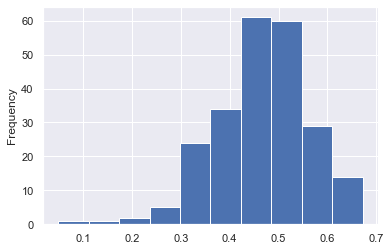

In [154]:
(X_default.proba - X_default.proba_min).plot.hist()
plt.show()

In [156]:
X_default[X_default.proba_min >= 0.5].sample(3)

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal_status,...,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,proba_min
832,< 0 DM,45,no credits taken/ all credits paid back duly,business,11816,... < 100 DM,.. >= 7 years,2,male,single,...,29,none,rent,2,skilled employee / official,1,none,yes,0.874828,0.549941
334,< 0 DM,24,no credits taken/ all credits paid back duly,radio/television,4110,... < 100 DM,.. >= 7 years,3,male,single,...,23,bank,rent,2,skilled employee / official,2,none,yes,0.866776,0.519487
728,0 <= ... < 200 DM,48,all credits at this bank paid back duly,business,6416,... < 100 DM,.. >= 7 years,4,female,divorced,...,59,none,rent,1,skilled employee / official,1,none,yes,0.925651,0.524549


### Poisoning

On remarque qu'il y a certaine personne pour qui la modification de variables difficilement vérifiables n'est pas suffisant. 
On passe donc à la deuxième attaque *poisoning*. On a vu précédemment que l'individu *232* fait partie des personnes ne pouvant pas utiliser la triche pour pouvoir être accepté.

On va rajouter sa ligne dans la base de donnée d'entrainement et voir si cela a un impact.

In [16]:
y = credit['default']
X = credit.drop(columns="default")

ind = X.iloc[[95]]

In [17]:
ind

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal_status,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
95,0 <= ... < 200 DM,54,no credits taken/ all credits paid back duly,business,15945,... < 100 DM,... < 1 year,3,male,single,...,4,unknown / no property,58,none,rent,1,skilled employee / official,1,"yes, registered under the customers name",yes


In [18]:
n = 9
X_train_pois = X_train.append([ind]*n, ignore_index=True)
y_train_pois = pd.Series(list(y_train) + [0]*n)

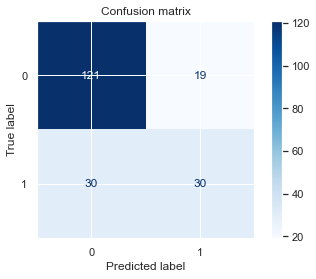

Sensitivity  Specificity   Precision     Accuracy  
    0.86         0.50         0.61         0.76    


In [19]:
mesure_clas(logreg, X_test, y_test)

In [20]:
logreg.predict_proba(ind)[0,1]

0.9303033801912368

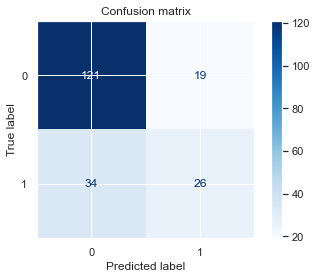

Sensitivity  Specificity   Precision     Accuracy  
    0.86         0.43         0.58         0.73    


In [21]:
logreg_pois = model.fit(X_train_pois, y_train_pois)

mesure_clas(logreg_pois, X_test, y_test)

In [22]:
logreg_pois.predict_proba(ind)[0,1]

0.47122487407898306

On automatise la recherche du nombre minimum de copie pour passer.

In [23]:
def min_pois(ind):
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    while model.fit(X_train_pois, y_train_pois).predict_proba(ind)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
    return n

In [24]:
min_pois(ind)

9

On regarde la distribution pour les personnes qui ont besoin du poisoning

In [25]:
list_min = X_false[X_false.proba_min > 0.5].drop(columns=['proba', 'proba_min']).apply(lambda x: min_pois(x.to_frame().transpose()), axis=1)

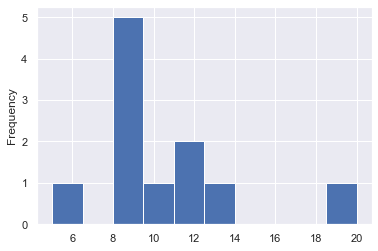

In [26]:
list_min.plot.hist()
plt.show()

On peut coupler les deux premières attaques pour avoir encore moins de copie à rajouter.

In [27]:
ind_best_comb = all_X[all_X['index_old'] == ind.index[0]].sort_values(by='proba').head(1)  \
                                            .drop(['index_old', 'proba'], axis=1)

In [28]:
print_diff(ind_best_comb.iloc[0], ind.iloc[0])

purpose           : business                    --> car (used)                                                   
present_emp_since : ... < 1 year                --> 4 <= ... < 7 years                                           
job               : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer


In [29]:
n = 2
X_train_pois_best = X_train.append([ind_best_comb]*n, ignore_index=True)
y_train_pois_best = pd.Series(list(y_train) + [0]*n)

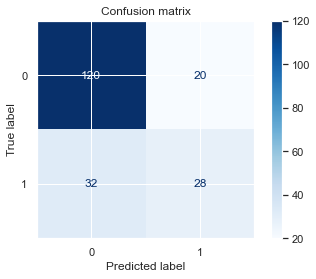

Sensitivity  Specificity   Precision     Accuracy  
    0.86         0.47         0.58         0.74    


In [30]:
logreg_pois_best = model.fit(X_train_pois_best, y_train_pois_best)

mesure_clas(logreg_pois_best, X_test, y_test)

In [31]:
logreg_pois_best.predict_proba(ind_best_comb)[0,1]

0.4932345933281425

On automatise

In [32]:
def min_pois_best_comb(ind, print_chan=True):
    ind_best_comb = all_X[all_X['index_old'] == ind.index[0]].sort_values(by='proba').head(1)  \
                                            .drop(['index_old', 'proba'], axis=1)

    print_diff(ind_best_comb.iloc[0], ind.iloc[0]) if print_chan else ...
    
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    while model.fit(X_train_pois, y_train_pois).predict_proba(ind_best_comb)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind_best_comb], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
    return n

In [33]:
min_pois_best_comb(ind)

purpose           : business                    --> car (used)                                                   
present_emp_since : ... < 1 year                --> 4 <= ... < 7 years                                           
job               : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer


2

In [34]:
%%capture
list_min_best_comb = X_false[X_false.proba_min > 0.5].apply(lambda x: 
                                                            min_pois_best_comb(x.to_frame().transpose(), False), axis=1)

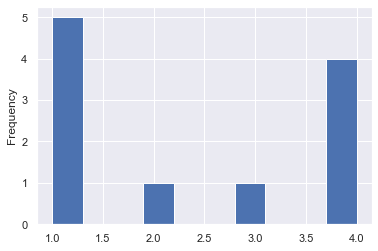

In [35]:
list_min_best_comb.plot.hist()
plt.show()

# Mitiger les dégâts

## Présentation des différentes solutions 

### Contrer l'*evasion*

### Contrer le *poisinig*

## Implémentation des méthodes et étude de cas

# Critique de la partie 2 et recommendations

## Comprendre les limites d'un modèle statistique

## Ouverture : différentes pistes de la *robustness*